<a href="https://colab.research.google.com/github/robinjmf/Music_Classification/blob/main/genre_classification_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import kagglehub
import shutil
import os


# Download latest version
path = kagglehub.dataset_download("andradaolteanu/gtzan-dataset-music-genre-classification")

print("Path to dataset files:", path)


# Define the target path
target_path = '/kaggle/working/gtzan-dataset-music-genre-classification'
os.makedirs(target_path, exist_ok=True)

# Move files from the download location to the target path
shutil.move(path, target_path)

print("Dataset successfully moved to:", target_path)

# print("Path to dataset files:", download_path)


100%|██████████| 1.21G/1.21G [00:17<00:00, 76.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1
Dataset successfully moved to: /kaggle/working/gtzan-dataset-music-genre-classification


# GTZAN - Deep Learning

`Music Genre Classification Problem`. Experts have been trying for a long time to understand sound & what differentiates one from another. How to visualize sound. What makes one tone different from another.

We are going to analyze the features extracted from the GTZAN dataset and build different type of ensemble models to see how better we can differentiate one genre from another.

Our Datasets contains 10 genres:-
- Blues
- Classical
- Country
- Disco
- Hiphop
- Jazz
- Metal
- Pop
- Reggae
- Rock


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import sklearn.metrics as skm
import sklearn.model_selection as skms
import sklearn.preprocessing as skp
import random
import librosa, IPython
import librosa.display as lplt
import math
seed = 12
np.random.seed(seed)

# CNN
Using keras layers of Conv2D, MaxPool2D, BatchNormalization.

CNN layers takes input primarily in 3D shape, so we again have to prepare the dataset in the form and for that, I have used np.newaxis function which adds a column/layer in the data

## Make MFCC features and Log Mel Spectrum

In [7]:

dataset_path = r"/kaggle/working/gtzan-dataset-music-genre-classification/1/Data/genres_original"
mfcc_json_path = r"mfcc_data.json"
logmel_json_path = r"logmel_data.json"
sample_rate = 22050
DURATION = 30
SAMPLES_PER_TRACK = sample_rate * DURATION

In [8]:
import os
import librosa
import json
import math
from IPython.display import clear_output

SAMPLE_RATE = 22050
SAMPLES_PER_TRACK = SAMPLE_RATE * 30  # Assuming 30 seconds per track

#Saving on Json format
def save_mfcc(dataset_path, json_path, n_mfcc=13, n_fft=2048,
              hop_length=512, num_segments=5, selected_genres=None):
    # Data storage dictionary
    data = {
        "mapping": [],
        "mfcc": [],
        "labels": [],
    }
    samples_ps = int(SAMPLES_PER_TRACK / num_segments)  # ps = per segment
    expected_vects_ps = math.ceil(samples_ps / hop_length)

    # Loop through all the genres
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        # Ensuring not at root
        if dirpath is not dataset_path:
            # Save the semantic label
            dirpath_comp = dirpath.split("/")
            semantic_label = dirpath_comp[-1]

            # Check if the genre is in the selected genres list (if provided)
            if selected_genres is None or semantic_label in selected_genres:
                data["mapping"].append(semantic_label)
                print(f"Processing: {semantic_label}")

                # Process files for specific genre
                for f in filenames:
                    if f == "jazz.00054.wav":
                        # As librosa only reads files <1Mb
                        continue
                    else:
                        # Load audio file
                        file_path = os.path.join(dirpath, f)
                        signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)
                        for s in range(num_segments):
                            start_sample = samples_ps * s
                            finish_sample = start_sample + samples_ps

                            mfcc = librosa.feature.mfcc(y=signal[start_sample:finish_sample],
                                                        sr=sr,
                                                        n_fft=n_fft,
                                                        n_mfcc=n_mfcc,
                                                        hop_length=hop_length)

                            mfcc = mfcc.T

                            # Store MFCC if it has the expected length
                            if len(mfcc) == expected_vects_ps:
                                data["mfcc"].append(mfcc.tolist())
                                data["labels"].append(i - 1)
                                print(f"{file_path}, segment: {s + 1}")

    # Save the data as a JSON file
    with open(json_path, "w") as f:
        json.dump(data, f, indent=4)

# Example usage:
# save_mfcc('dataset_path', 'output.json', selected_genres=['classical', 'rock'])


In [9]:
import os
import librosa
import json
import math
import numpy as np

#Saving on Json Format
def save_log_mel_spectrogram(dataset_path, json_path, n_mels=128, n_fft=2048,
                             hop_length=512, num_segments=5, selected_genres=None):
    data = {"mapping": [], "log_mel": [], "labels": []}
    samples_ps = int(SAMPLES_PER_TRACK / num_segments)
    expected_vects_ps = math.ceil(samples_ps / hop_length)  # Adjusted

    for dirpath, dirnames, filenames in os.walk(dataset_path):
        if dirpath != dataset_path:
            semantic_label = os.path.basename(dirpath)
            if selected_genres is None or semantic_label in selected_genres:
                data["mapping"].append(semantic_label)
                print(f"Processing genre: {semantic_label} ({len(filenames)} files)")

                for f in filenames:
                    if not f.endswith(".wav"):
                        continue

                    file_path = os.path.join(dirpath, f)
                    try:
                        signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)
                    except Exception as e:
                        print(f"🚨 Error loading {file_path}: {e}")
                        continue

                    for s in range(num_segments):
                        start_sample = samples_ps * s
                        finish_sample = start_sample + samples_ps
                        mel_spectrogram = librosa.feature.melspectrogram(
                            y=signal[start_sample:finish_sample],
                            sr=sr, n_fft=n_fft,
                            hop_length=hop_length, n_mels=n_mels
                        )
                        log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max).T

                        # Fix 1: Accept shorter segments (at least 80% of expected length)
                        if len(log_mel_spectrogram) >= expected_vects_ps * 0.8:
                            # Fix 2: Pad if needed
                            if len(log_mel_spectrogram) < expected_vects_ps:
                                pad_width = expected_vects_ps - len(log_mel_spectrogram)
                                log_mel_spectrogram = np.pad(log_mel_spectrogram, ((0, pad_width), (0, 0)), mode='constant')

                            data["log_mel"].append(log_mel_spectrogram.tolist())
                            # Ensure consistent indexing
                            if semantic_label not in data["mapping"]:
                              data["mapping"].append(semantic_label)

                            label = data["mapping"].index(semantic_label)  # Assign correct index
                            data["labels"].append(label)

                            print(f"✅ Saved {file_path}, segment {s+1} (New Shape: {log_mel_spectrogram.shape})")
                        else:
                            print(f"🚨 Skipping {file_path}, segment {s+1} (Too short, Shape: {log_mel_spectrogram.shape})")

    if len(data["log_mel"]) > 0:
        print(f"✅ Saving {len(data['log_mel'])} samples to {json_path}...")
        with open(json_path, "w") as f:
            json.dump(data, f, indent=4)
    else:
        print("🚨 No data to save! JSON file will remain empty.")


In [10]:
# import os
# import librosa
# import h5py
# import math
# import numpy as np

# # Ensure that SAMPLES_PER_TRACK is defined (e.g., for 30 seconds at 22050 Hz)
# SAMPLE_RATE = 22050
# DURATION = 30
# SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION

# def save_log_mel_spectrogram_hdf5(dataset_path, hdf5_path, n_mels=128, n_fft=2048,
#                                   hop_length=512, num_segments=5, selected_genres=None):
#     """
#     Process audio files from dataset_path to extract log Mel spectrogram features,
#     and save the results into an HDF5 file at hdf5_path.

#     The data saved includes:
#       - "mapping": a list of genre names (one per directory)
#       - "log_mel": a 3D array of spectrograms (each of shape (expected_vects_ps, n_mels))
#       - "labels": an array of integer labels corresponding to each spectrogram

#     Args:
#         dataset_path (str): Path to the dataset folder containing genre subdirectories.
#         hdf5_path (str): Path to save the HDF5 file.
#         n_mels (int): Number of Mel bands.
#         n_fft (int): FFT window size.
#         hop_length (int): Hop length.
#         num_segments (int): Number of segments to split each track.
#         selected_genres (list or None): List of genres to process (if None, process all).
#     """
#     data = {"mapping": [], "log_mel": [], "labels": []}
#     samples_ps = int(SAMPLES_PER_TRACK / num_segments)
#     expected_vects_ps = math.ceil(samples_ps / hop_length)

#     # Normalize selected_genres to lowercase for consistent comparison.
#     if selected_genres is not None:
#         selected_genres = [genre.lower() for genre in selected_genres]

#     # --- Pre-collect all valid genre names ---
#     genre_set = set()
#     for dirpath, dirnames, filenames in os.walk(dataset_path):
#         if dirpath == dataset_path:
#             continue
#         semantic_label = os.path.basename(dirpath).lower()  # Normalize folder name
#         if selected_genres is None or semantic_label in selected_genres:
#             genre_set.add(semantic_label)
#     # Create a sorted mapping for consistency.
#     data["mapping"] = sorted(list(genre_set))
#     print(f"✅ Genre Mapping: {data['mapping']}")

#     # --- Process Each Genre Folder ---
#     for dirpath, dirnames, filenames in os.walk(dataset_path):
#         if dirpath == dataset_path:
#             continue
#         semantic_label = os.path.basename(dirpath).lower()  # Normalize folder name
#         if semantic_label not in data["mapping"]:
#             continue  # Skip genres not in the mapping

#         print(f"Processing genre: {semantic_label} ({len(filenames)} files)")
#         for f in filenames:
#             if not f.endswith(".wav"):
#                 continue
#             file_path = os.path.join(dirpath, f)
#             try:
#                 signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)
#             except Exception as e:
#                 print(f"🚨 Error loading {file_path}: {e}")
#                 continue
#             for s in range(num_segments):
#                 start_sample = samples_ps * s
#                 finish_sample = start_sample + samples_ps
#                 mel_spectrogram = librosa.feature.melspectrogram(
#                     y=signal[start_sample:finish_sample],
#                     sr=sr, n_fft=n_fft,
#                     hop_length=hop_length, n_mels=n_mels
#                 )
#                 log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max).T

#                 # Accept segments that are at least 80% of the expected length.
#                 if len(log_mel_spectrogram) >= expected_vects_ps * 0.8:
#                     # Pad the segment if it's shorter than expected.
#                     if len(log_mel_spectrogram) < expected_vects_ps:
#                         pad_width = expected_vects_ps - len(log_mel_spectrogram)
#                         log_mel_spectrogram = np.pad(log_mel_spectrogram, ((0, pad_width), (0, 0)), mode='constant')

#                     # Append the processed spectrogram.
#                     data["log_mel"].append(log_mel_spectrogram.tolist())
#                     # Get the label (genre index) from the mapping.
#                     label = data["mapping"].index(semantic_label)
#                     data["labels"].append(label)
#                     print(f"✅ Saved {file_path}, segment {s+1} (Shape: {log_mel_spectrogram.shape}, Label: {label})")
#                 else:
#                     print(f"🚨 Skipping {file_path}, segment {s+1} (Too short, Shape: {log_mel_spectrogram.shape})")

#     # --- Save to HDF5 ---
#     if len(data["log_mel"]) > 0:
#         print(f"✅ Saving {len(data['log_mel'])} samples to {hdf5_path}...")
#         # Convert lists to numpy arrays.
#         log_mel_array = np.array(data["log_mel"])   # Shape: (num_samples, expected_vects_ps, n_mels)
#         labels_array = np.array(data["labels"], dtype=np.int32)
#         mapping_array = np.array(data["mapping"], dtype="S")  # Save mapping as ASCII byte strings.

#         with h5py.File(hdf5_path, "w") as hf:
#             hf.create_dataset("log_mel", data=log_mel_array, compression="gzip")
#             hf.create_dataset("labels", data=labels_array, compression="gzip")
#             hf.create_dataset("mapping", data=mapping_array, compression="gzip")
#         print("✅ Data successfully saved to HDF5!")
#     else:
#         print("🚨 No data to save! HDF5 file will remain empty.")


# #Save on disk (low speed but confident on not crashing)
# import os
# import math
# import librosa
# import numpy as np
# import h5py

# SAMPLE_RATE = 22050
# DURATION = 30
# SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION

# def save_log_mel_spectrogram_hdf5(dataset_path, hdf5_path, n_mels=128, n_fft=2048,
#                                   hop_length=512, num_segments=5, selected_genres=None,
#                                   augment=True, noise_level=0.005):
#     """
#     Memory-efficient HDF5 feature extraction with on-disk processing and augmentation
#     """

#     samples_ps = int(SAMPLES_PER_TRACK / num_segments)
#     expected_vects_ps = math.ceil(samples_ps / hop_length)

#     with h5py.File(hdf5_path, "w") as hf:
#         # Features dataset - critical chunking parameters
#         features = hf.create_dataset(
#             "log_mel",
#             shape=(0, expected_vects_ps, n_mels, 1),
#             maxshape=(None, expected_vects_ps, n_mels, 1),
#             chunks=(32, expected_vects_ps, n_mels, 1),  # <-- Chunk shape must match dimensions
#             compression="gzip",
#             dtype=np.float32
#         )

#         # Labels dataset - added chunking
#         labels_ds = hf.create_dataset(
#             "labels",
#             shape=(0,),
#             maxshape=(None,),
#             chunks=(1024,),  # <-- Added chunk size for 1D array
#             compression="gzip",
#             dtype=np.int32
#         )

#         # Mapping dataset - fixed size (no resizing needed)
#         mapping_ds = hf.create_dataset(
#             "mapping",
#             dtype=h5py.special_dtype(vlen=str),
#             shape=(0,),
#             maxshape=(None,),
#             chunks=(1,)  # <-- Chunking for resizable string dataset
#         )

#         # Build genre mapping
#         genres = sorted([d for d in os.listdir(dataset_path)
#                         if os.path.isdir(os.path.join(dataset_path, d)) and
#                         (selected_genres is None or d.lower() in selected_genres)])
#         genre_to_idx = {g:i for i,g in enumerate(genres)}
#         mapping_ds.resize((len(genres),))
#         mapping_ds[:] = genres

#         # Process files with progress tracking
#         total_samples = 0
#         for genre_idx, genre in enumerate(genres):
#             genre_path = os.path.join(dataset_path, genre)
#             print(f"Processing {genre} ({genre_idx+1}/{len(genres)})")

#             for f in os.listdir(genre_path):
#                 if not f.endswith(".wav"):
#                     continue

#                 file_path = os.path.join(genre_path, f)
#                 try:
#                     signal, _ = librosa.load(file_path, sr=SAMPLE_RATE)
#                 except Exception as e:
#                     print(f"Skipping {file_path}: {e}")
#                     continue

#                 # Process segments
#                 for s in range(num_segments):
#                     start = s * samples_ps
#                     end = start + samples_ps
#                     segment = signal[start:end]

#                     # Generate augmented variants
#                     segments = [segment]
#                     if augment:
#                         # Pitch shift
#                         segments.append(librosa.effects.pitch_shift(segment, sr=SAMPLE_RATE, n_steps=2))
#                         segments.append(librosa.effects.pitch_shift(segment, sr=SAMPLE_RATE, n_steps=-2))

#                         # Time stretch (with padding)
#                         for rate in [0.9, 1.1]:
#                             stretched = librosa.effects.time_stretch(segment, rate=rate)
#                             if len(stretched) < len(segment):
#                                 stretched = np.pad(stretched, (0, len(segment)-len(stretched)))
#                             else:
#                                 stretched = stretched[:len(segment)]
#                             segments.append(stretched)

#                         # Add noise
#                         noise = np.random.normal(0, noise_level, segment.shape)
#                         segments.append(segment + noise)

#                     # Process each variant
#                     for variant in segments:
#                         mel = librosa.feature.melspectrogram(
#                             y=variant, sr=SAMPLE_RATE,
#                             n_fft=n_fft, hop_length=hop_length, n_mels=n_mels
#                         )
#                         log_mel = librosa.power_to_db(mel, ref=np.max).T

#                         # Normalize
#                         log_mel = (log_mel - np.mean(log_mel)) / (np.std(log_mel) + 1e-8)

#                         # Pad/truncate
#                         if log_mel.shape[0] < expected_vects_ps:
#                             pad = ((0, expected_vects_ps - log_mel.shape[0]), (0, 0))
#                             log_mel = np.pad(log_mel, pad, mode='constant')
#                         else:
#                             log_mel = log_mel[:expected_vects_ps]

#                         # Write to HDF5
#                         new_size = total_samples + 1
#                         features.resize((new_size, expected_vects_ps, n_mels, 1))
#                         labels_ds.resize((new_size,))

#                         features[total_samples] = log_mel[..., np.newaxis]
#                         labels_ds[total_samples] = genre_idx
#                         total_samples += 1

#         print(f"Saved {total_samples} samples to {hdf5_path}")

In [14]:
import os
import librosa
import h5py
import math
import numpy as np

# Ensure that SAMPLES_PER_TRACK is defined (e.g., for 30 seconds at 22050 Hz)
SAMPLE_RATE = 22050
DURATION = 30
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION

def save_log_mel_spectrogram_hdf5(dataset_path, hdf5_path, n_mels=128, n_mfcc=13,
                                  n_fft=2048, hop_length=512, num_segments=5,
                                  selected_genres=None, feature_type="log_mel"):
    """
    Process audio files to extract either Log-Mel Spectrograms or MFCCs
    and save them in an HDF5 file.

    The data saved includes:
      - "mapping": a list of genre names (one per directory)
      - "features": a 3D array of chosen features (log_mel or mfcc)
      - "labels": an array of integer labels corresponding to each sample

    Args:
        dataset_path (str): Path to the dataset folder containing genre subdirectories.
        hdf5_path (str): Path to save the HDF5 file.
        n_mels (int): Number of Mel bands (for Log-Mel Spectrograms).
        n_mfcc (int): Number of MFCC coefficients (for MFCCs).
        n_fft (int): FFT window size.
        hop_length (int): Hop length.
        num_segments (int): Number of segments to split each track.
        selected_genres (list or None): List of genres to process (if None, process all).
        feature_type (str): Either "log_mel" or "mfcc" (which feature to extract).
    """
    data = {"mapping": [], "features": [], "labels": []}
    samples_ps = int(SAMPLES_PER_TRACK / num_segments)
    expected_vects_ps = math.ceil(samples_ps / hop_length)

    # Normalize selected_genres to lowercase for consistent comparison.
    if selected_genres is not None:
        selected_genres = [genre.lower() for genre in selected_genres]

    # --- Pre-collect all valid genre names ---
    genre_set = set()
    for dirpath, dirnames, filenames in os.walk(dataset_path):
        if dirpath == dataset_path:
            continue
        semantic_label = os.path.basename(dirpath).lower()
        if selected_genres is None or semantic_label in selected_genres:
            genre_set.add(semantic_label)
    data["mapping"] = sorted(list(genre_set))
    print(f"✅ Genre Mapping: {data['mapping']}")

    # --- Process Each Genre Folder ---
    for dirpath, dirnames, filenames in os.walk(dataset_path):
        if dirpath == dataset_path:
            continue
        semantic_label = os.path.basename(dirpath).lower()
        if semantic_label not in data["mapping"]:
            continue  # Skip genres not in the mapping

        print(f"Processing genre: {semantic_label} ({len(filenames)} files)")
        for f in filenames:
            if not f.endswith(".wav"):
                continue
            file_path = os.path.join(dirpath, f)
            try:
                signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)
            except Exception as e:
                print(f"🚨 Error loading {file_path}: {e}")
                continue
            for s in range(num_segments):
                start_sample = samples_ps * s
                finish_sample = start_sample + samples_ps

                if feature_type == "log_mel":
                    spectrogram = librosa.feature.melspectrogram(
                        y=signal[start_sample:finish_sample],
                        sr=sr, n_fft=n_fft,
                        hop_length=hop_length, n_mels=n_mels
                    )
                    feature = librosa.power_to_db(spectrogram, ref=np.max).T

                elif feature_type == "mfcc":
                    feature = librosa.feature.mfcc(
                        y=signal[start_sample:finish_sample],
                        sr=sr, n_mfcc=n_mfcc,
                        hop_length=hop_length).T

                else:
                    raise ValueError("feature_type must be 'log_mel' or 'mfcc'.")

                # Accept segments that are at least 80% of the expected length.
                if len(feature) >= expected_vects_ps * 0.8:
                    pad_width = expected_vects_ps - len(feature)
                    if pad_width > 0:
                        feature = np.pad(feature, ((0, pad_width), (0, 0)), mode='constant')

                    data["log_mel"].append(feature.tolist())
                    label = data["mapping"].index(semantic_label)
                    data["labels"].append(label)

    # --- Save to HDF5 ---
    if len(data["features"]) > 0:
        print(f"✅ Saving {len(data['features'])} samples to {hdf5_path}...")
        with h5py.File(hdf5_path, "w") as hf:
            hf.create_dataset("features", data=np.array(data["features"]), compression="gzip")
            hf.create_dataset("labels", data=np.array(data["labels"], dtype=np.int32), compression="gzip")
            hf.create_dataset("mapping", data=np.array(data["mapping"], dtype="S"), compression="gzip")
        print("✅ Data successfully saved to HDF5!")
    else:
        print("🚨 No data to save! HDF5 file will remain empty.")


In [11]:
# save_mfcc(dataset_path, mfcc_json_path, num_segments=10)
# clear_output()

In [12]:
# save_log_mel_spectrogram(dataset_path, logmel_json_path, num_segments=5, selected_genres=genres)
# # clear_output()

In [15]:
hdf5_path = "logmel_data.h5"            # Output HDF5 file
# Delete the file if it already exists
if os.path.exists(hdf5_path):
    os.remove(hdf5_path)
selected_genres = ["classical", "disco", "blues", "country", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]
# selected_genres = ["classical", "disco","metal"]

# Create features with augmentation
save_log_mel_spectrogram_hdf5(
    dataset_path=dataset_path,
    hdf5_path=hdf5_path,
    num_segments=5,
    selected_genres=selected_genres
)

# save_log_mel_spectrogram_hdf5(dataset_path, hdf5_path, n_mels=128, n_fft=2048,
#                               hop_length=512, num_segments=5, selected_genres=selected_genres)


✅ Genre Mapping: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
Processing genre: reggae (100 files)
Processing genre: disco (100 files)
Processing genre: pop (100 files)
Processing genre: country (100 files)
Processing genre: blues (100 files)
Processing genre: jazz (100 files)
🚨 Error loading /kaggle/working/gtzan-dataset-music-genre-classification/1/Data/genres_original/jazz/jazz.00054.wav: 
Processing genre: rock (100 files)
Processing genre: hiphop (100 files)
Processing genre: metal (100 files)
Processing genre: classical (100 files)
✅ Saving 4995 samples to logmel_data.h5...
✅ Data successfully saved to HDF5!


In [12]:
!pip install ijson

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.2/119.2 kB 4.5 MB/s eta 0:00:00


In [17]:
# import ijson

# with open("logmel_data.json", "r") as f:
#     top_keys = set()  # Store found keys
#     for prefix, event, value in ijson.parse(f):
#         if prefix and "." not in prefix:  # Top-level keys only
#             top_keys.add(prefix)
#         if len(top_keys) >= 5:  # Stop early after 5 keys
#             break

# print("Top-Level Keys:", top_keys)


In [18]:
!ps aux --sort=-%mem | head -n 10


USER         PID %CPU %MEM    VSZ   RSS TTY      STAT START   TIME COMMAND
root         259 99.0 17.9 3716068 2386484 ?     Ssl  22:14   5:28 /usr/bin/python3 -m colab_kernel_
root         333 10.3  2.1 1064400 282136 ?      Sl   22:14   0:33 node /datalab/web/pyright/pyright
root          89  1.6  0.9 366100 123644 ?       Sl   22:13   0:05 /usr/bin/python3 /usr/local/bin/j
root           7  0.9  0.5 907292 66800 ?        Sl   22:13   0:03 /tools/node/bin/node /datalab/web
root          68  0.2  0.3  63792 51476 ?        S    22:13   0:00 python3 /usr/local/bin/colab-file
root          12  1.7  0.1 1237844 22828 ?       Sl   22:13   0:06 /usr/colab/bin/kernel_manager_pro
root         298  0.4  0.1 545560 21260 ?        Sl   22:14   0:01 /usr/bin/python3 /usr/local/lib/p
root         303  0.0  0.1 1240728 20040 ?       Sl   22:14   0:00 /usr/colab/bin/language_service -
root          90  0.1  0.0 1230316 9508 ?        Sl   22:13   0:00 /usr/local/bin/dap_multiplexer --


In [3]:

import json
import numpy as np
from tensorflow.keras.utils import to_categorical

# def split_data_generator(dataset_path, file_format="json", selected_genres=None, batch_size=64,
#                          split="train", test_size=0.25, validation_size=0.2,
#                          data_key="mfcc", return_label_map=False):
#     """
#     A generator to load batches of data dynamically from a JSON or HDF5 file.

#     Args:
#         dataset_path (str): Path to the data file (JSON or HDF5).
#         file_format (str): "json" or "h5" to indicate the file format.
#         selected_genres (list): List of genre names to filter the data.
#         batch_size (int): Number of samples per batch.
#         split (str): "train", "validation", or "test".
#         test_size (float): Fraction of data to use for testing.
#         validation_size (float): Fraction of training data to use for validation.
#         data_key (str): Key to access features in the file ("mfcc" or "log_mel").
#         return_label_map (bool): If True, yield (inputs_batch, targets_batch, label_map).

#     Yields:
#         For training: (inputs_batch, targets_batch) or (inputs_batch, targets_batch, label_map)
#     """
#     if file_format.lower() == "json":
#         with open(dataset_path, "r") as f:
#             data = json.load(f)
#         total_samples = len(data[data_key])
#     elif file_format.lower() == "h5":
#         import h5py
#         hf = h5py.File(dataset_path, "r")
#         # For HDF5, we load mapping fully; the heavy arrays are kept as h5py datasets.
#         data = {}
#         data["mapping"] = [x.decode("utf-8") for x in hf["mapping"][:]]
#         data[data_key] = hf[data_key]   # This is an h5py dataset that supports slicing.
#         data["labels"] = hf["labels"]     # This is an h5py dataset.
#         total_samples = data[data_key].shape[0]
#     else:
#         raise ValueError("Unsupported file format. Use 'json' or 'h5'.")

#     # Create indices and shuffle
#     indices = np.arange(total_samples)
#     np.random.shuffle(indices)

#     # Split dataset indices
#     num_test_samples = int(test_size * total_samples)
#     num_validation_samples = int(validation_size * (total_samples - num_test_samples))
#     if split == "test":
#         split_indices = indices[:num_test_samples]
#     elif split == "validation":
#         split_indices = indices[num_test_samples:num_test_samples + num_validation_samples]
#     else:  # "train"
#         split_indices = indices[num_test_samples + num_validation_samples:]

#     if len(split_indices) == 0:
#         print(f"🚨 No data available for split: {split}. Exiting generator.")
#         return

#     # Prepare label_map for selected genres
#     if selected_genres is not None:
#         # Normalize selected genres to lowercase
#         selected_genres = [genre.lower() for genre in selected_genres]
#         # For both file types, use the mapping from the data.
#         if file_format.lower() == "json":
#             genre_mapping = [g.lower() for g in data["mapping"]]
#         else:  # h5
#             genre_mapping = [g.lower() for g in data["mapping"]]
#         # Get indices in genre_mapping corresponding to selected genres.
#         selected_indices = [genre_mapping.index(genre) for genre in selected_genres if genre in genre_mapping]
#         print(f"Selected genre indices: {selected_indices}")
#         label_map = {old_label: idx for idx, old_label in enumerate(selected_indices)}
#     else:
#         if file_format.lower() == "json":
#             label_map = {i: i for i in range(10)}
#         else:
#             label_map = {i: i for i in range(len(data["mapping"]))}
#         selected_indices = list(label_map.keys())

#     while True:
#         data_found = False
#         for start_idx in range(0, len(split_indices), batch_size):
#             end_idx = min(start_idx + batch_size, len(split_indices))
#             batch_indices = split_indices[start_idx:end_idx]

#             if file_format.lower() == "json":
#                 inputs_batch = np.array([data[data_key][i] for i in batch_indices])
#                 targets_batch = np.array([data["labels"][i] for i in batch_indices])
#             else:  # h5: sort the batch_indices because h5py requires indices in increasing order.
#                 sorted_indices = np.sort(batch_indices)
#                 inputs_batch = np.array(data[data_key][sorted_indices])
#                 targets_batch = np.array(data["labels"][sorted_indices])

#             if selected_genres is not None:
#                 mask = np.isin(targets_batch, selected_indices)
#                 if not np.any(mask):
#                     print("🚨 No data left after filtering by selected genres! Skipping batch.")
#                     continue
#                 inputs_batch = inputs_batch[mask]
#                 targets_batch = targets_batch[mask]
#                 targets_batch = np.array([label_map[target] for target in targets_batch])

#             if inputs_batch.shape[0] == 0:
#                 print("🚨 Empty batch detected! Skipping...")
#                 continue

#             data_found = True
#             targets_batch = to_categorical(targets_batch, num_classes=len(label_map))
#             inputs_batch = np.expand_dims(inputs_batch, axis=-1)

#             if return_label_map:
#                 yield inputs_batch, targets_batch, label_map
#             else:
#                 yield inputs_batch, targets_batch

#         if not data_found:
#             print("🚨 No valid data found in entire dataset. Stopping generator.")
#             break

#     if file_format.lower() == "h5":
#         hf.close()


# #suitable for the save function on disk
# def split_data_generator(hdf5_path, batch_size=64, split="train",
#                         test_size=0.25, validation_size=0.2,
#                         selected_genres=None, augment=False,
#                         time_mask=5, freq_mask=5):
#     """
#     Memory-efficient generator with on-the-fly augmentation
#     """
#     with h5py.File(hdf5_path, "r") as hf:
#         # Get indices and splits
#         total_samples = hf["labels"].shape[0]
#         indices = np.arange(total_samples)
#         np.random.shuffle(indices)

#         # Calculate splits
#         num_test = int(test_size * total_samples)
#         num_val = int(validation_size * (total_samples - num_test))

#         if split == "test":
#             split_indices = indices[:num_test]
#         elif split == "validation":
#             split_indices = indices[num_test:num_test+num_val]
#         else:
#             split_indices = indices[num_test+num_val:]

#         # Filter by genre if needed
#         if selected_genres:
#             all_labels = hf["labels"][:]
#             all_genres = [g.decode() for g in hf["mapping"][:]]
#             selected_idxs = [i for i,g in enumerate(all_genres) if g.lower() in selected_genres]
#             genre_mask = np.isin(all_labels, selected_idxs)
#             split_indices = split_indices[genre_mask[split_indices]]

#         # Pre-shuffle training data
#         if split == "train":
#             np.random.shuffle(split_indices)

#         # Get dataset references
#         features = hf["log_mel"]
#         labels = hf["labels"]
#         num_classes = len(hf["mapping"])

#         while True:
#           for start in range(0, len(split_indices), batch_size):
#             end = min(start + batch_size, len(split_indices))
#             batch_indices = split_indices[start:end]

#             # Sort batch_indices to satisfy HDF5's requirement
#             batch_indices = np.sort(batch_indices)

#             # Get batch data
#             X_batch = features[batch_indices]
#             y_batch = labels[batch_indices]

#             # Apply augmentation
#             if augment:
#                 X_batch = apply_spec_augment(X_batch, time_mask, freq_mask)

#             # Convert labels to categorical
#             y_batch = to_categorical(y_batch, num_classes=num_classes)

#             yield X_batch, y_batch

# def apply_spec_augment(batch, time_mask, freq_mask):
#     """
#     Apply spec augmentation to a batch of spectrograms.
#     Handles both 3D (batch_size, time_steps, freq_bins) and 4D (batch_size, time_steps, freq_bins, channels) inputs.
#     """
#     augmented = batch.copy()
#     for i in range(augmented.shape[0]):
#         # Time masking
#         if time_mask > 0:
#             t = np.random.randint(0, time_mask)
#             t0 = np.random.randint(0, augmented.shape[1] - t)
#             if len(augmented.shape) == 4:  # 4D input
#                 augmented[i, t0:t0+t, :, :] = 0
#             else:  # 3D input
#                 augmented[i, t0:t0+t, :] = 0

#         # Frequency masking
#         if freq_mask > 0:
#             f = np.random.randint(0, freq_mask)
#             f0 = np.random.randint(0, augmented.shape[2] - f)
#             if len(augmented.shape) == 4:  # 4D input
#                 augmented[i, :, f0:f0+f, :] = 0
#             else:  # 3D input
#                 augmented[i, :, f0:f0+f] = 0

#     return augmented


In [48]:
import json
import numpy as np
import librosa
import librosa.effects
from tensorflow.keras.utils import to_categorical

def augment_sample(sample, sr):
    """
    Augment log-mel spectrograms while preserving their shape.
    - Pitch Shift
    - Time Stretch
    - Add White Noise
    - Reverse Spectrogram

    Args:
        sample (numpy array): Log-Mel spectrogram (shape: time-frames x n_mels)
        sr (int): Sample rate.

    Returns:
        list: Augmented versions of the sample (same shape as input)
    """
    augmented_samples = [sample]  # Start with the original sample

    # 1. Pitch Shift
    pitch_shifted = librosa.effects.pitch_shift(y=sample.T, sr=sr, n_steps=np.random.uniform(-3, 3)).T
    augmented_samples.append(pitch_shifted)

    # 2. Time Stretch (Ensure Consistent Shape)
    stretch_factor = np.random.uniform(0.8, 1.2)
    stretched = librosa.effects.time_stretch(y=sample.T, rate=stretch_factor).T
    if stretched.shape[0] < sample.shape[0]:
        stretched = np.pad(stretched, ((0, sample.shape[0] - stretched.shape[0]), (0, 0)), mode="constant")
    elif stretched.shape[0] > sample.shape[0]:
        stretched = stretched[:sample.shape[0], :]
    augmented_samples.append(stretched)

    # 3. Add White Noise
    noise = np.random.randn(*sample.shape) * 0.005  # Match shape
    noisy_sample = sample + noise
    augmented_samples.append(noisy_sample)

    # 4. Reverse the Spectrogram (Flip along time-axis)
    reversed_sample = np.flip(sample, axis=0)
    augmented_samples.append(reversed_sample)

    return augmented_samples


def split_data_generator(dataset_path, file_format="h5", selected_genres=None, batch_size=64,
                         split="train", test_size=0.25, validation_size=0.2,
                         data_key="features", return_label_map=False, augment=True):
    """
    Generator that loads and yields batches from JSON or HDF5 files.

    Args:
        dataset_path (str): Path to the dataset file.
        file_format (str): "json" or "h5" to indicate the file type.
        selected_genres (list): List of genres to use (or None for all).
        batch_size (int): Number of samples per batch.
        split (str): "train", "validation", or "test".
        test_size (float): Fraction for testing.
        validation_size (float): Fraction for validation.
        data_key (str): "features" (Log Mel/MFCC) key in file.
        return_label_map (bool): If True, yields label_map with batch.
        augment (bool): Whether to apply data augmentation.

    Yields:
        Tuple: (inputs_batch, targets_batch) or (inputs_batch, targets_batch, label_map)
    """

    if file_format.lower() == "json":
        with open(dataset_path, "r") as f:
            data = json.load(f)
        total_samples = len(data[data_key])
    elif file_format.lower() == "h5":
        hf = h5py.File(dataset_path, "r")
        data = {
            "mapping": [x.decode("utf-8") for x in hf["mapping"][:]],
            "features": hf[data_key],  # Dataset stored in HDF5 format
            "labels": hf["labels"]
        }
        total_samples = data["features"].shape[0]
    else:
        raise ValueError("Unsupported file format. Use 'json' or 'h5'.")

    # Create shuffled indices
    indices = np.arange(total_samples)
    np.random.shuffle(indices)

    # Split dataset indices
    num_test_samples = int(test_size * total_samples)
    num_validation_samples = int(validation_size * (total_samples - num_test_samples))
    if split == "test":
        split_indices = indices[:num_test_samples]
    elif split == "validation":
        split_indices = indices[num_test_samples:num_test_samples + num_validation_samples]
    else:
        split_indices = indices[num_test_samples + num_validation_samples:]

    if len(split_indices) == 0:
        print(f"🚨 No data available for {split}. Exiting generator.")
        return

    # Prepare label map for selected genres
    if selected_genres is not None:
        selected_genres = [g.lower() for g in selected_genres]
        genre_mapping = [g.lower() for g in data["mapping"]]
        selected_indices = [genre_mapping.index(g) for g in selected_genres if g in genre_mapping]
        print(f"Selected genre indices: {selected_indices}")
        label_map = {old_label: idx for idx, old_label in enumerate(selected_indices)}
    else:
        label_map = {i: i for i in range(len(data["mapping"]))}
        selected_indices = list(label_map.keys())

    while True:
        data_found = False
        for start_idx in range(0, len(split_indices), batch_size):
            end_idx = min(start_idx + batch_size, len(split_indices))
            batch_indices = split_indices[start_idx:end_idx]

            if file_format.lower() == "json":
                inputs_batch = np.array([data[data_key][i] for i in batch_indices])
                targets_batch = np.array([data["labels"][i] for i in batch_indices])
            else:  # HDF5 format (sorting required for indexing)
                sorted_indices = np.sort(batch_indices)
                inputs_batch = np.array(data["features"][sorted_indices])
                targets_batch = np.array(data["labels"][sorted_indices])

            if selected_genres is not None:
                mask = np.isin(targets_batch, selected_indices)
                if not np.any(mask):
                    print("🚨 No data left after filtering by selected genres! Skipping batch.")
                    continue
                inputs_batch = inputs_batch[mask]
                targets_batch = targets_batch[mask]
                targets_batch = np.array([label_map[target] for target in targets_batch])

            if inputs_batch.shape[0] == 0:
                print("🚨 Empty batch detected! Skipping...")
                continue

            # Apply Augmentation (only on training set)
            if augment and split == "train":
                augmented_inputs = []
                augmented_labels = []

                for i, sample in enumerate(inputs_batch):
                    aug_samples = augment_sample(sample, SAMPLE_RATE)  # Apply augmentation
                    augmented_inputs.extend(aug_samples)  # Add all augmented versions
                    augmented_labels.extend([targets_batch[i]] * len(aug_samples))  # Duplicate labels

                # Convert lists to numpy arrays
                inputs_batch = np.array(augmented_inputs)
                targets_batch = np.array(augmented_labels)

            data_found = True
            targets_batch = to_categorical(targets_batch, num_classes=len(label_map))
            inputs_batch = np.expand_dims(inputs_batch, axis=-1)

            # print(f"✅ Batch Inputs Shape: {inputs_batch.shape}")
            # print(f"✅ Batch Labels Shape: {targets_batch.shape}")

            if return_label_map:
                yield inputs_batch, targets_batch, label_map
            else:
                yield inputs_batch, targets_batch

        if not data_found:
            print("🚨 No valid data found in entire dataset. Stopping generator.")
            break

    if file_format.lower() == "h5":
        hf.close()

In [44]:
# from google.colab import drive
# drive.mount('/content/drive')


In [49]:
# train_gen = split_data_generator(
#     dataset_path="logmel_data.h5",   # Use the HDF5 file here
#     file_format="h5",                # Specify that the file format is HDF5
#     selected_genres=selected_genres,
#     batch_size=32,
#     split="train",
#     test_size=0.25,
#     validation_size=0.2,
#     data_key="log_mel"             # Access Log Mel Spectrogram features
# )

# val_gen = split_data_generator(
#     dataset_path="logmel_data.h5",   # Use the HDF5 file here
#     file_format="h5",                # Specify that the file format is HDF5
#     selected_genres=selected_genres,
#     batch_size=32,
#     split="validation",
#     test_size=0.25,
#     validation_size=0.2,
#     data_key="log_mel"            # Access Log Mel Spectrogram features
# )


# Create augmented training generator
train_gen = split_data_generator(
    dataset_path="logmel_data.h5",
    file_format="h5",
    selected_genres=selected_genres,
    batch_size=64,
    split="train",
    test_size=0.25,
    validation_size=0.2,
    data_key="features",
    augment=True  # ✅ Enable augmentation
)


# Create non-augmented validation generator
val_gen = split_data_generator(
    dataset_path="logmel_data.h5",
    file_format="h5",
    selected_genres=selected_genres,
    batch_size=64,
    split="validation",
    test_size=0.25,
    validation_size=0.2,
    data_key="features",
    augment=False  # ✅ Enable augmentation
)

inputs_batch, targets_batch= next(train_gen)
print("Batch shape (HDF5):", inputs_batch.shape)


Selected genre indices: [1, 3, 0, 2, 4, 5, 6, 7, 8, 9]
✅ Batch Inputs Shape: (320, 259, 128, 1)
✅ Batch Labels Shape: (320, 10)
✅ Batch Inputs Shape: (320, 259, 128, 1)
✅ Batch Labels Shape: (320, 10)
Batch shape (HDF5): (320, 259, 128, 1)


In [15]:
# # Try fetching one batch
# print("Fetching batch 1...")
# inputs_batch, targets_batch = next(train_gen)
# print(f"Batch 1 loaded successfully! Shape: {inputs_batch.shape}")

In [32]:
input_shape = inputs_batch.shape[1:]  # Exclude batch dimension
print("Input Shape:", input_shape)

Input Shape: (259, 128, 1)


In [33]:
import h5py
from collections import Counter

# Path to your HDF5 file
hdf5_path = "logmel_data.h5"

with h5py.File(hdf5_path, "r") as hf:
    # Load the mapping dataset and decode byte strings to regular strings
    mapping = hf["mapping"][:]
    mapping = [m.decode("utf-8") for m in mapping]

    # Load labels (they are stored as integers)
    labels = hf["labels"][:]

print("Genre Mapping from HDF5:")
for idx, genre in enumerate(mapping):
    print(f"  {idx}: {genre}")

# Count how many times each label appears
label_counts = Counter(labels)
print("\nLabel Distribution:")
for label, count in label_counts.items():
    # Use the mapping to show the genre name for each label
    genre_name = mapping[label] if label < len(mapping) else "Unknown"
    print(f"  Label {label} ({genre_name}): {count} samples")


Genre Mapping from HDF5:
  0: blues
  1: classical
  2: country
  3: disco
  4: hiphop
  5: jazz
  6: metal
  7: pop
  8: reggae
  9: rock

Label Distribution:
  Label 8 (reggae): 500 samples
  Label 3 (disco): 500 samples
  Label 7 (pop): 500 samples
  Label 2 (country): 500 samples
  Label 0 (blues): 500 samples
  Label 5 (jazz): 495 samples
  Label 9 (rock): 500 samples
  Label 4 (hiphop): 500 samples
  Label 6 (metal): 500 samples
  Label 1 (classical): 500 samples


In [ ]:
# gen = split_data_generator(
#     dataset_path="logmel_data.h5",
#     file_format="h5",
#     selected_genres=selected_genres,  # e.g., genres = ["classical", "disco", "blues", ...]
#     batch_size=16,
#     split="train",
#     test_size=0.25,
#     validation_size=0.2,
#     data_key="log_mel",
#     return_label_map=True  # Return label_map for debugging
# )

# inputs_batch, targets_batch, label_map = next(gen)
# print("Label map from generator:", label_map)

In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Flatten, MaxPooling2D, BatchNormalization, Dropout, GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam

num_classes = len(selected_genres)  # Your list of genres (e.g., 10 for 10 genres)

model = Sequential()

# First convolution block
model.add(Conv2D(64, (3, 3), activation="relu", input_shape=input_shape, padding="same"))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), strides=(2, 2)))
model.add(Dropout(0.3))

# Second convolution block
model.add(Conv2D(128, (3, 3), activation="relu", padding="same"))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), strides=(2, 2)))
model.add(Dropout(0.3))

# Third convolution block
model.add(Conv2D(128, (3, 3), activation="relu", padding="same"))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), strides=(2, 2)))
model.add(Dropout(0.3))

# Fourth convolution block (optional, if the input size permits)
model.add(Conv2D(128, (3, 3), activation="relu", padding="same"))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), strides=(2, 2)))
model.add(Dropout(0.3))

# Global average pooling reduces the spatial dimensions to 1 per channel
model.add(Flatten())


# Fully connected layers
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation="softmax"))

model.summary()

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 259, 128, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 259, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 129, 64, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 129, 64, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 129, 64, 128)        │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 129, 64, 128)        │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 64, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 64, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 64, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 32, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 32, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 32, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 16, 8, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 16, 8, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │       1,048,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,420,746 (5.42 MB)

 Trainable params: 1,419,850 (5.42 MB)

 Non-trainable params: 896 (3.50 KB)

In [51]:
# checking and matching between train and validation generator

inputs_batch, targets_batch = next(train_gen)
print("Train batch shape:", inputs_batch.shape, targets_batch.shape)

inputs_batch, targets_batch = next(val_gen)
print("Validation batch shape:", inputs_batch.shape, targets_batch.shape)


Train batch shape: (320, 259, 128, 1) (320, 10)
Selected genre indices: [1, 3, 0, 2, 4, 5, 6, 7, 8, 9]
Validation batch shape: (64, 259, 128, 1) (64, 10)


In [52]:
hist = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10
)



Epoch 1/10
     57/Unknown 889s 16s/step - accuracy: 0.1052 - loss: 2.7524

KeyboardInterrupt: 

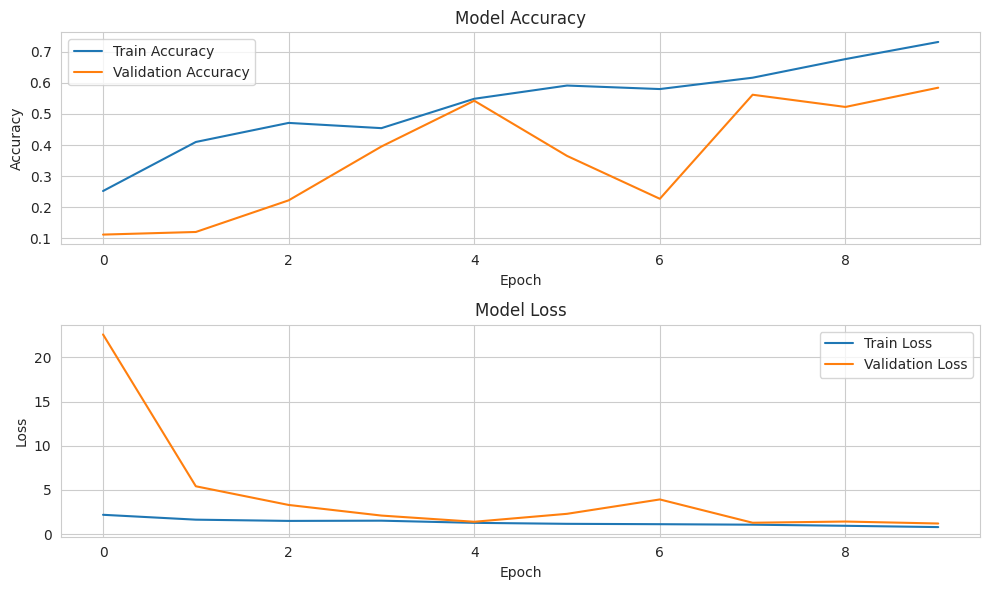

In [27]:
import matplotlib.pyplot as plt

def plot_history(history):
    """Plots training & validation loss and accuracy."""
    fig, axs = plt.subplots(2, figsize=(10, 6))

    # Plot accuracy
    axs[0].plot(history.history['accuracy'], label="Train Accuracy")
    axs[0].plot(history.history['val_accuracy'], label="Validation Accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].set_xlabel("Epoch")
    axs[0].set_title("Model Accuracy")
    axs[0].legend()

    # Plot loss
    axs[1].plot(history.history['loss'], label="Train Loss")
    axs[1].plot(history.history['val_loss'], label="Validation Loss")
    axs[1].set_ylabel("Loss")
    axs[1].set_xlabel("Epoch")
    axs[1].set_title("Model Loss")
    axs[1].legend()

    plt.tight_layout()
    plt.show()


plot_history(hist)


In [28]:
test_gen = split_data_generator(
    dataset_path="logmel_data.h5",
    selected_genres=genres,
    batch_size=16,
    split="test",  # Use the test split
    test_size=0.25,  # Ensure test split exists
    validation_size=0.2,
    data_key="log_mel"
)

test_steps = 25  # Adjust based on dataset size

# Evaluate on test set
test_error, test_accuracy = model.evaluate(test_gen, steps=test_steps, verbose=1)
print(f"Test Accuracy: {test_accuracy:.4f}")


FileNotFoundError: [Errno 2] No such file or directory: 'logmel_data.json'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model, test_gen, label_map, test_steps=50):
    """
    Plots a confusion matrix for the model's predictions on test data.

    Args:
        model: Trained model.
        test_gen: Data generator for test data.
        label_map: Dictionary mapping labels to genre indices.
        test_steps: Number of steps (batches) to run for evaluation.
    """
    # Get test data and predictions
    y_true = []
    y_pred = []

    for _ in range(test_steps):
        X_batch, y_batch = next(test_gen)  # Fetch batch
        predictions = model.predict(X_batch)  # Get model predictions

        y_true.extend(np.argmax(y_batch, axis=1))  # Convert one-hot to label indices
        y_pred.extend(np.argmax(predictions, axis=1))  # Get predicted labels

    # Convert indices back to genre names
    genre_labels = list(label_map.keys())

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=genre_labels, yticklabels=genre_labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()



In [ ]:
# Create test generator with label_map
test_gen = split_data_generator(
    dataset_path="logmel_data.json",
    selected_genres=["classical", "disco", "metal"],  # Same genres as training
    batch_size=16,
    split="test",
    test_size=0.25,
    validation_size=0.2,
    data_key="log_mel",
    return_label_map=True  # Get label_map
)

# Get first batch to extract label_map
_, _, label_map = next(test_gen)

# Reinitialize test generator (because next() consumes one batch)
test_gen = split_data_generator(
    dataset_path="logmel_data.json",
    selected_genres=["classical", "disco", "metal"],
    batch_size=16,
    split="test",
    test_size=0.25,
    validation_size=0.2,
    data_key="log_mel"
)

# Plot the confusion matrix
plot_confusion_matrix(model, test_gen, label_map, test_steps=25)
